# Quantum Interference and Stabilisation

This notebook explores the **connections between optical interferometers (MZI and Michelson)**, **qubit-based Ramsey interferometry**, and how these concepts lead naturally to the **stabilisation protocol** we will later apply to the **Galton board model**.

---

## Mach–Zehnder Interferometer (MZI)

The **Mach–Zehnder interferometer** is a fundamental optical setup:
- A single photon is split at a **beam splitter (BS)** into two paths.
- A **phase shift φ** is applied in one path.
- A second beam splitter recombines the paths, leading to interference fringes at the detectors.

Mathematically:

MZI = BS . P. BS

**Takeaways:**
- Output probabilities oscillate sinusoidally with φ.
- This is directly analogous to qubit interference on the Bloch sphere.

### Run Simulation


In [1]:
import os
os.chdir("../..")
print(os.getcwd())

/home/ismail/quantum_python/quantum_nnl_project


In [2]:
from src.unitary_sims.mzi import *
from src.unitary_sims.michelson import * 
from src.unitary_sims.ramsey import * 
from src.quantum_circuits.mzi import mzi_circuit
from src.quantum_circuits.michelson import michelson_circuit
from src.quantum_circuits.ramsey import ramsey_circuit
from utils.plot_utils import plot_fringe
from utils.distance_metrics_utils import *
import matplotlib.pyplot as plt

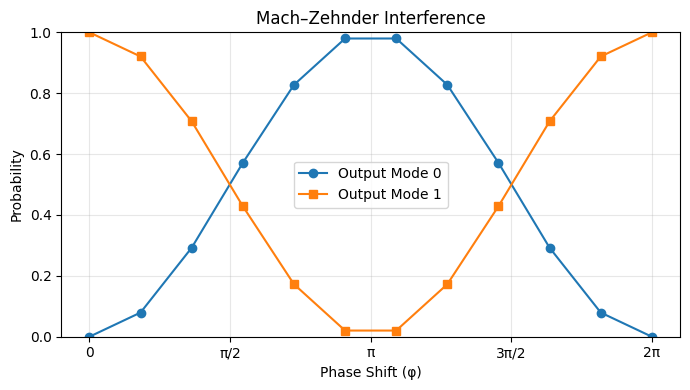

In [3]:
phases, results = mzi(intervals=12)
plot_fringe(phases=phases, results=results)

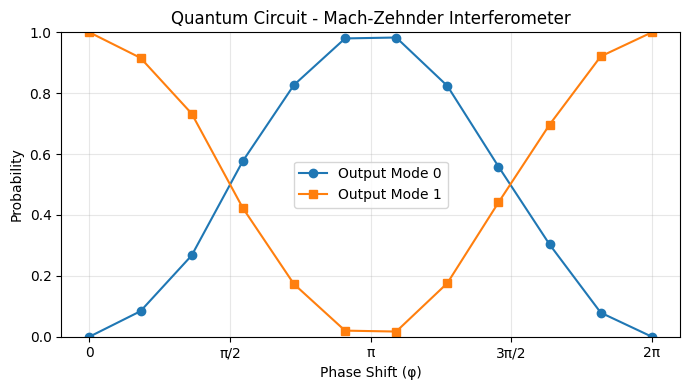

In [4]:
qphases, qresults = mzi_circuit(intervals=12)
plot_fringe(phases=qphases, results=qresults, title="Quantum Circuit - Mach-Zehnder Interferometer")

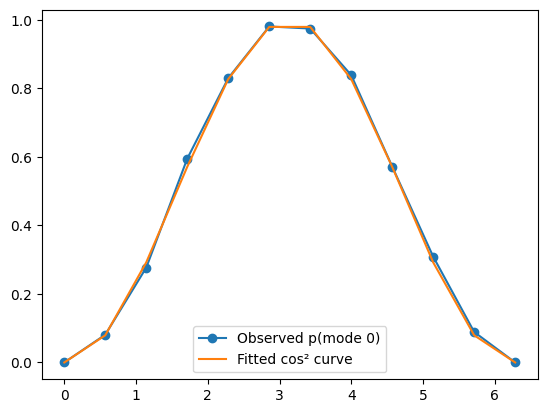

In [5]:
def cos2_model(x, amplitude=1, offset=0, freq=0.5, phase_shift=np.pi/2):
    return offset + amplitude * np.cos(freq * x + phase_shift)**2
qphases, qprobs = mzi_circuit(intervals=12)
plt.plot(qphases, [p[0] for p in qprobs], 'o-', label='Observed p(mode 0)')
plt.plot(qphases, cos2_model(qphases), label='Fitted cos² curve')
plt.legend()
plt.show()


## Michelson Interferometer

The **Michelson interferometer** is historically significant (Michelson–Morley experiment) and physically distinct:

- It uses a single beam splitter twice (split and recombine after reflection from mirrors).
- Despite this hardware difference, its mathematical transformation is equivalent to MZI, producing the same interference fringes.

We include Michelson here as a conceptual bridge to further show the link between physical experiment and qubit simulation.

- Note: We won't re-implement Michelson separately in code, since it reduces to the same BS–phase–BS transformation as MZI.

**Takeaways:**
- Output probabilities oscillate sinusoidally with φ.
- This is (still) directly analogous to qubit interference on the Bloch sphere.

### Run Simulation


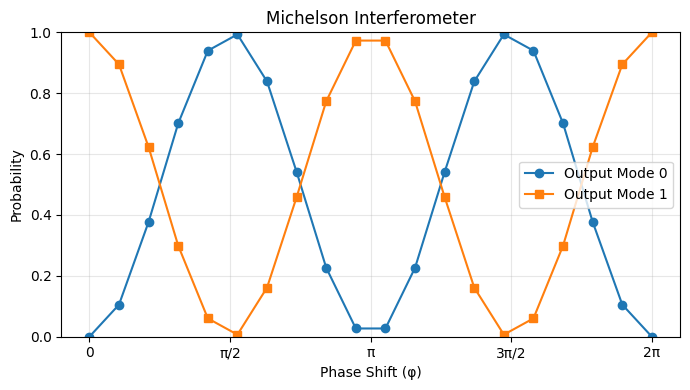

In [6]:
phases, results = michelson(intervals=20)
plot_fringe(phases=phases, results=results, title="Michelson Interferometer")

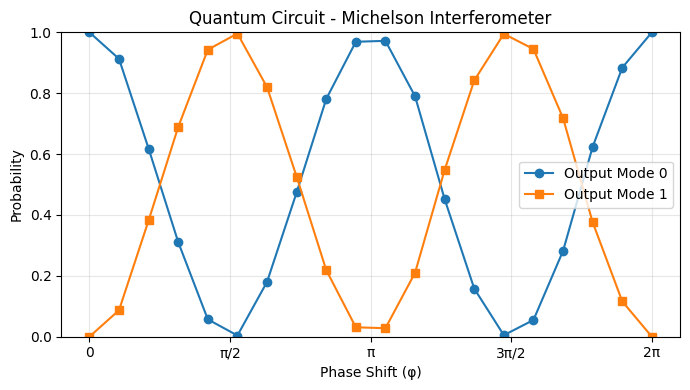

In [7]:
qphases, qresults = michelson_circuit(intervals=20)
plot_fringe(phases=qphases, results=qresults, title="Quantum Circuit - Michelson Interferometer")

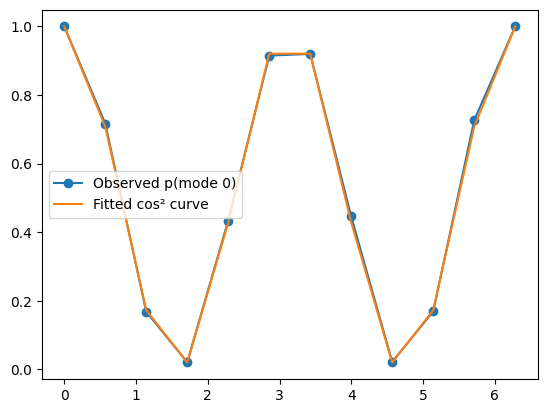

In [8]:
qphases, qprobs = michelson_circuit(intervals=12)
plt.plot(qphases, [p[0] for p in qprobs], 'o-', label='Observed p(mode 0)')
plt.plot(qphases, cos2_model(qphases, freq=1.0, phase_shift=0.0, amplitude=1.0), label='Fitted cos² curve')
plt.legend()
plt.show()

## Ramsey Interferometry (Qubit Analog)

Ramsey interferometry is the qubit equivalent of optical interference:

- A qubit starts in $|0\rangle$.
- A Hadamard gate creates a superposition (analogous to BS splitting paths).
- A phase accumulation step rotates the qubit about $Z$ (analogous to path phase delay).
- A second Hadamard recombines the paths.
- Measuring in the computational basis yields fringes identical to MZI.

    P(∣1⟩) = [1−cos⁡(ϕ)]/2


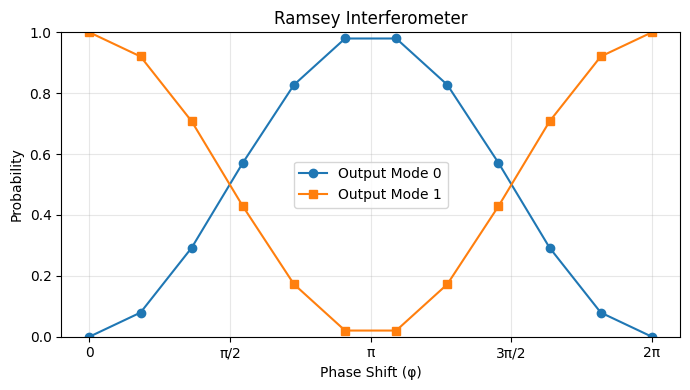

In [9]:
phases, results = ramsey(intervals=12)
plot_fringe(phases=phases, results=results, title="Ramsey Interferometer")

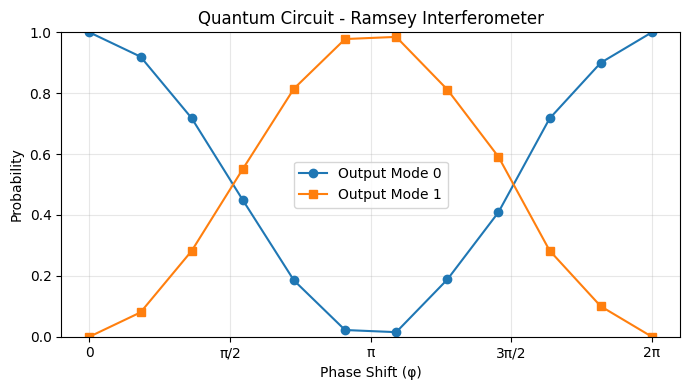

In [10]:
qphases, qresults = ramsey_circuit(intervals=12)
plot_fringe(phases=qphases, results=qresults, title="Quantum Circuit - Ramsey Interferometer")

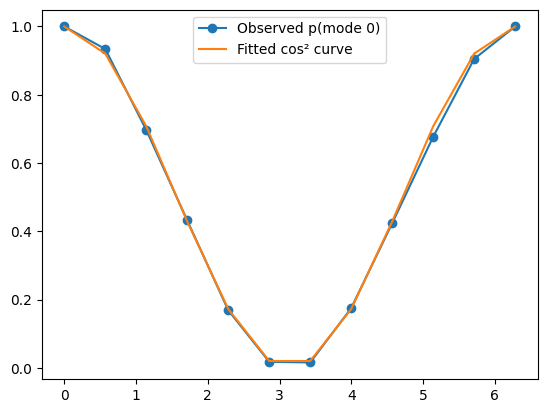

In [11]:
def cos2_model(x, amplitude=1, offset=0, freq=0.5, phase_shift=np.pi/2):
    return offset + amplitude * np.cos(freq * x + phase_shift)**2
qphases, qprobs = ramsey_circuit(intervals=12)
plt.plot(qphases, [p[0] for p in qprobs], 'o-', label='Observed p(mode 0)')
plt.plot(qphases, cos2_model(qphases, phase_shift=0.0), label='Fitted cos² curve')
plt.legend()
plt.show()

## Combined Plot

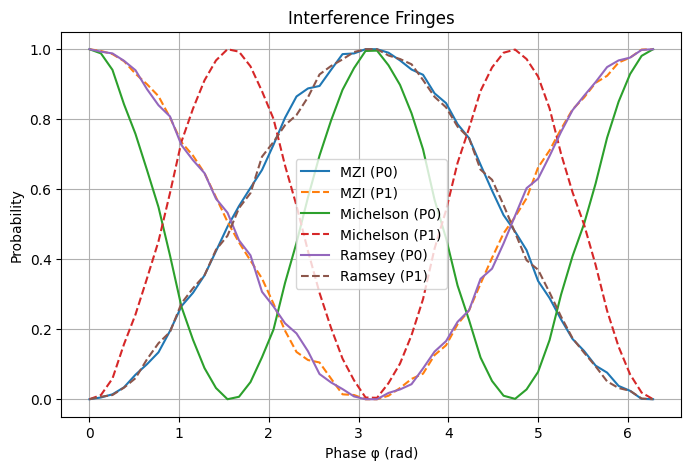

In [12]:
plt.figure(figsize=(8,5))
mzi_circuit(intervals=50, plot=True)
michelson_circuit(intervals=50, plot=True)
ramsey_circuit(intervals=50, plot=True)

plt.xlabel("Phase φ (rad)")
plt.ylabel("Probability")
plt.title("Interference Fringes")
plt.legend()
plt.grid(True)
plt.show()

## Noise and Decoherence in Ramsey

In real systems, qubits experience dephasing ($T_2$), causing Ramsey fringes to lose contrast:

The probability curve dampens over time with the following rule:

P(∣1⟩)=12[1−e−t/T2cos⁡(Δω t)]
P(∣1⟩)=21​[1−e−t/T2​cos(Δωt)]

This demonstrates why coherence is the limiting factor in interferometry-based sensing.
## Run Noisy Ramsey Simulation

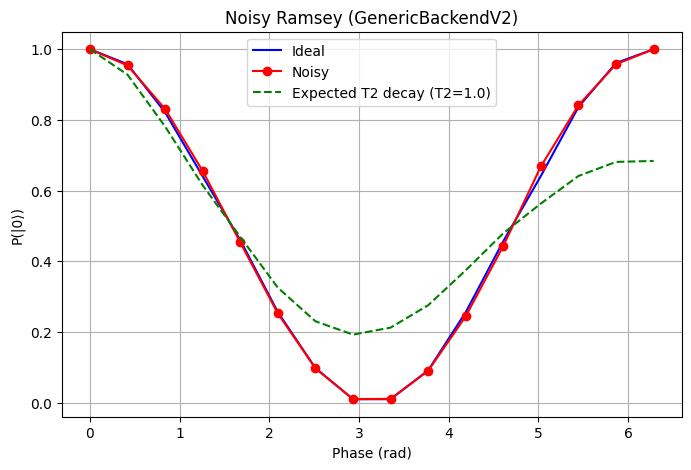

In [13]:
from src.decoherence_timing.timing import *

# Run
phases = np.linspace(0, 2 * np.pi, 16)

# Ideal simulation
ideal_probs = [ramsey_probability_phase(phi, noise=False) for phi in phases]

# Noisy simulation with GenericBackendV2 (2 qubits so CX fits)
backend = GenericBackendV2(num_qubits=2)
noisy_probs = [ramsey_probability_phase(phi, noise=True, backend=backend) for phi in phases]

# Plot with artificial T2 envelope
plot_ramsey_fringe(phases, ideal_probs, noisy_probs, t2=1.0, title="Noisy Ramsey (GenericBackendV2)")


Whilst some tendency can be seen of the noise model towards the delay expected, clearly this noise model is not extreme enough to show the damping effect. We intended to use a custom noise model from Aer's thermal noise package but ran out of time unfortunately.

## From Ramsey to Stabilization

The stabilization protocol (from the referenced paper) extends Ramsey:

- During the free evolution (phase accumulation), a continuous control drive is applied.
- This drive dynamically corrects the qubit's phase and preserves coherence.

The Hamiltonian for stabilization is:

see equation 2

Where:

- $\Delta sigma$ is the detuning (phase evolution rate).

- $h_y(t)$ is a dynamically updated control term based on the Bloch vector.

In a gate-based simulator, we Trotterize this:

see equation 3-5

This breaks continuous control into small $R_z$ and $R_y$ gates applied repeatedly.

## Applying Stabilization to the Galton Board

Finally, we transfer these insights to our quantum Galton board:

- The control qubit in the Galton board is analogous to the Ramsey qubit.
- Between each "layer" (peg scattering), we apply stabilization pulses derived from Ramsey control.
- This preserves coherence across multiple layers, maintaining ideal biased distributions even under noise.

Potential Improvements (we ran out of time to test properly):

- Baseline Galton board output under noise.
- Stabilized Galton board output with Ramsey-inspired control.
- Fidelity and KL divergence comparisons.

In [14]:
from src.stabilised_galton.stabilised_galton import *

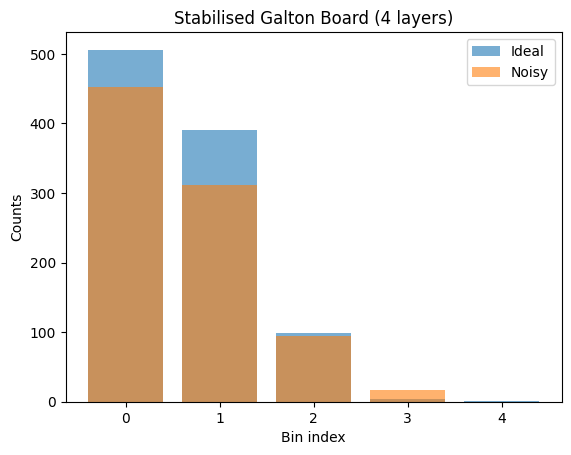

In [15]:
n = 4
thetas = np.linspace(np.pi/3, np.pi/6, n)

counts_ideal = stabilised_galton_n_layer(n, thetas, steps=8, noise=False)
counts_noisy = stabilised_galton_n_layer(n, thetas, steps=8, noise=True)

plt.bar(counts_ideal.keys(), counts_ideal.values(), alpha=0.6, label="Ideal")
plt.bar(counts_noisy.keys(), counts_noisy.values(), alpha=0.6, label="Noisy")
plt.xlabel("Bin index")
plt.ylabel("Counts")
plt.title(f"Stabilised Galton Board ({n} layers)")
plt.legend()
plt.show()


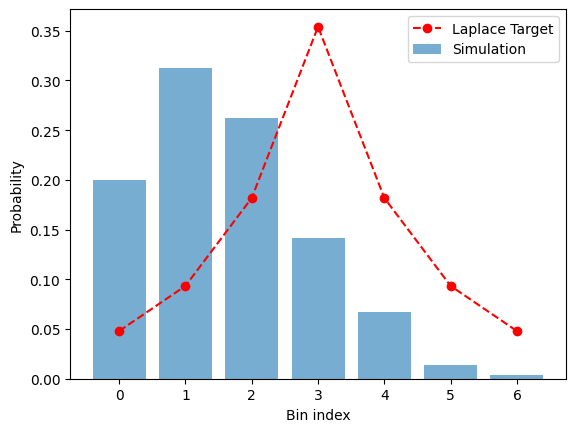

In [16]:
def target_laplace_distribution(n_bins, decay_factor=1.0):
    center = n_bins // 2
    bins = np.arange(n_bins + 1)
    probs = np.exp(-np.abs(bins - center) / decay_factor)
    return probs / np.sum(probs)

n = 6
thetas = np.linspace(np.pi/2.1, np.pi/5, n)
laplace_target = target_laplace_distribution(n, decay_factor=1.5)

counts = stabilised_galton_n_layer(n, thetas, steps=6, noise=True)
probs = np.array(list(counts.values())) / sum(counts.values())

plt.bar(range(n+1), probs, alpha=0.6, label="Simulation")
plt.plot(range(n+1), laplace_target, "ro--", label="Laplace Target")
plt.xlabel("Bin index")
plt.ylabel("Probability")
plt.legend()
plt.show()


(We did write the optimiser to get the distribution more accurate, but unfortunately ran out of time to use it here. The intended purpose of the plot is more intended to show the more gradual and balanced decay, making it significantly easier to achieve exponential decay.)

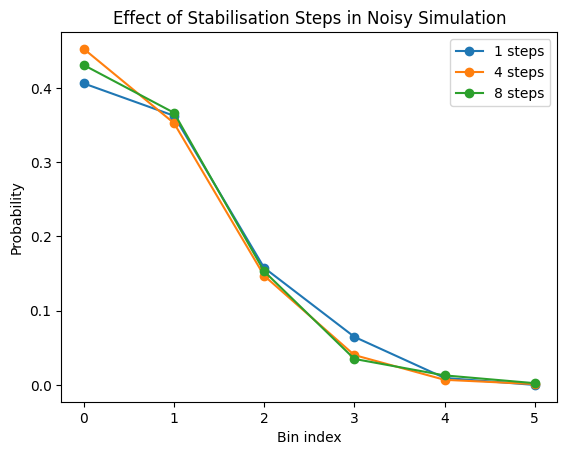

In [17]:
n = 5
thetas = [np.pi/4] * n

for steps in [1, 4, 8]:
    counts = stabilised_galton_n_layer(n, thetas, steps=steps, noise=True)
    probs = np.array(list(counts.values())) / sum(counts.values())
    plt.plot(range(n+1), probs, "o-", label=f"{steps} steps")

plt.xlabel("Bin index")
plt.ylabel("Probability")
plt.title("Effect of Stabilisation Steps in Noisy Simulation")
plt.legend()
plt.show()


The effects of our stabilisation routine, showing the slower decay of the probabilities. 